# Setup

In [6]:
import wandb
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Data

In [11]:
# Create some synthetic data
N = 1000
X = np.random.random((N,2)) * 6 - 3
Y = np.cos(2*X[:,0]) + np.cos(3*X[:,1])

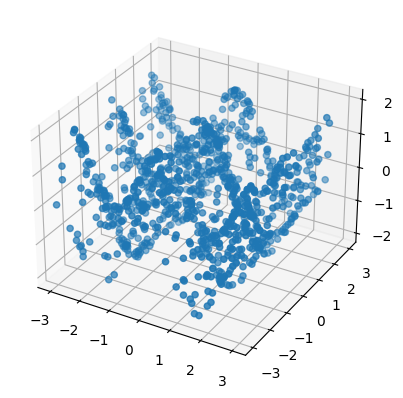

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], Y)

# Model

In [10]:
# Configure the wandb sweep
sweep_config = {
    'method': 'bayes',
    'metric': {
      'name': 'loss',
      'goal': 'minimize'   
    },
    'parameters': {
        'learning_rate': {
            'values': [1, 0.1, 0.01, 0.001, 0.0001]
        },
        'epochs': {
            'values': [10, 20, 50, 100, 150, 200]
        },
        'batch_size': {
            'values': [16, 32, 64, 128, 256]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'sgd', 'rmsprop']
        },
        'layers': {
            'values': [1, 2, 3, 4, 5]
        },
    }
}

In [14]:
# Initialise sweep
sweep_id = wandb.sweep(sweep_config, project='tensorflow-test', entity='kavp')

Create sweep with ID: eb4sqnjk
Sweep URL: https://wandb.ai/kavp/tensorflow-test/sweeps/eb4sqnjk


In [15]:
# Mega function to define and train model and log results (used by the sweep)
def sweep_func():
    # Default hyperparameter values
    config_defaults = {
        'learning_rate': 0.001,
        'epochs': 100,
        'batch_size': 128,
        'optimizer': 'adam',
        'layers': 1,
        'eager_mode': False,
    }

    # Initialise run
    wandb.init(config=config_defaults)

    # Variable to hold the sweep values
    config = wandb.config
    
    if config['eager_mode'] == True:
        tf.compat.v1.enable_eager_execution()
    elif config['eager_mode'] == False:
        tf.compat.v1.disable_eager_execution()
    else:
        raise ValueError('eager_mode property of wandb config could not be determined.') 

    # Define model with 1 layer
    model = tf.keras.models.Sequential([tf.keras.layers.Dense(128, input_shape=(2,), activation='relu')])

    # Account for the layer already in the model
    num_layers = config['layers'] - 1

    # Fill model with dense layers based on layers parameter
    for i in range(num_layers):
        model.add(tf.keras.layers.Dense(round(64/(i+1)), activation='relu'))

    # Add output layer
    model.add(tf.keras.layers.Dense(1))

    model.compile(
        optimizer=config['optimizer'],
        loss='mse',
        run_eagerly=config['eager_mode'],
    )

    with tf.compat.v1.Session() as sess:
        r = model.fit(X, Y, epochs=config['epochs'], batch_size=config['batch_size'])
        wandb.tensorflow.log(tf.compat.v1.summary.merge_all())
        wandb.log({'loss': r.history['loss'][-1]})

        wandb_data = [[x,y] for (x,y) in zip(np.arange(0, config['epochs'], 1), r.history['loss'])]
        table = wandb.Table(data=wandb_data, columns = ["epoch", "loss"])
        wandb.log({"loss_against_epochs" : wandb.plot.line(table, "epoch", "loss", title="Training loss")})

        # Save model
        model.save(os.path.join(wandb.run.dir, 'model.h5'))

In [ ]:
wandb.agent(sweep_id, sweep_func)

In [17]:
wandb.finish()

# Predictions

In [5]:
# Load a good run
good_run_path = 'kavp/tensorflow-test/peg7e42p/'
run = wandb.Api().run(good_run_path)
# Load model
best_model = wandb.restore('model.h5', run_path=good_run_path)
# Load config
config = run.config

# Recreate model architecture
model = tf.keras.models.Sequential([tf.keras.layers.Dense(128, input_shape=(2,), activation='relu')])
num_layers = config['layers'] - 1
for i in range(num_layers):
    model.add(tf.keras.layers.Dense(round(64/(i+1)), activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.compile(
    optimizer=config['optimizer'],
    loss='mse',
    run_eagerly=config['eager_mode'],
)

# Load its weights into the new model
model.load_weights(best_model.name)

79/79 [==============================] - 0s 785us/step


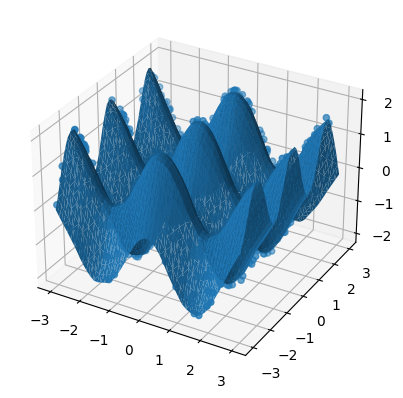

In [16]:
# Plot the prediction surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], Y)

line = np.linspace(-3, 3, 50)
xx, yy = np.meshgrid(line, line)
Xgrid = np.vstack((xx.flatten(), yy.flatten())).T
Yhat = model.predict(Xgrid).flatten()
ax.plot_trisurf(Xgrid[:,0], Xgrid[:,1], Yhat, linewidth=0.2, antialiased=True)
plt.show()

# Extrapolate

79/79 [==============================] - 0s 835us/step


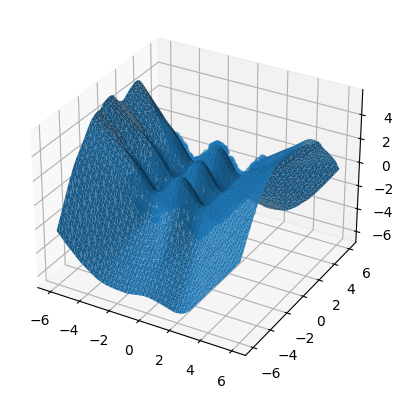

" The model doesn't use a periodic activation function, so it cannot extrapolate a periodic function very well. "

In [26]:
# Plot the prediction surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], Y)

line = np.linspace(-6, 6, 50)
xx, yy = np.meshgrid(line, line)
Xgrid = np.vstack((xx.flatten(), yy.flatten())).T
Yhat = model.predict(Xgrid).flatten()
ax.plot_trisurf(Xgrid[:,0], Xgrid[:,1], Yhat, linewidth=0.2, antialiased=True)
plt.show()

''' The model doesn't use a periodic activation function, so it cannot extrapolate a periodic function very well. '''